In [9]:
from copy import copy
from time import time

import matplotlib.pyplot as plt
import pandas as pd

from HARK.Calibration.Income.IncomeTools import (
    CGM_income,
    parse_income_spec,
    parse_time_params,
)
from HARK.ConsumptionSaving.ConsBequestModel import (
    BequestWarmGlowConsumerType,
    init_warm_glow,
)
from HARK.datasets.life_tables.us_ssa.SSATools import parse_ssa_life_table
from HARK.datasets.SCF.WealthIncomeDist.SCFDistTools import income_wealth_dists_from_scf
from HARK.utilities import plot_funcs

In [10]:
birth_age = 25
death_age = 120
adjust_infl_to = 1992
income_calib = CGM_income
education = "College"

# Income specification
income_params = parse_income_spec(
    age_min=birth_age,
    age_max=death_age,
    adjust_infl_to=adjust_infl_to,
    **income_calib[education],
    SabelhausSong=True,
)

# Initial distribution of wealth and permanent income
dist_params = income_wealth_dists_from_scf(
    base_year=adjust_infl_to,
    age=birth_age,
    education=education,
    wave=1995,
)

# We need survival probabilities only up to death_age-1, because survival
# probability at death_age is 1.
liv_prb = parse_ssa_life_table(
    female=True,
    cross_sec=True,
    year=2004,
    min_age=birth_age,
    max_age=death_age - 1,
)

# Parameters related to the number of periods implied by the calibration
time_params = parse_time_params(age_birth=birth_age, age_death=death_age)

# Update all the new parameters
params = copy(init_warm_glow)
params.update(time_params)
params.update(dist_params)
params.update(income_params)
params.update({"LivPrb": liv_prb})

In [11]:
# Make and solve an idiosyncratic shocks consumer with a finite lifecycle
Agent = BequestWarmGlowConsumerType(**params)
# Make this consumer live a sequence of periods exactly once
Agent.cycles = 1

In [12]:
start_time = time()
Agent.solve()
end_time = time()
print(f"Solving a lifecycle consumer took {end_time - start_time} seconds.")
Agent.unpack("cFunc")

Solving a lifecycle consumer took 0.04669356346130371 seconds.


Consumption functions


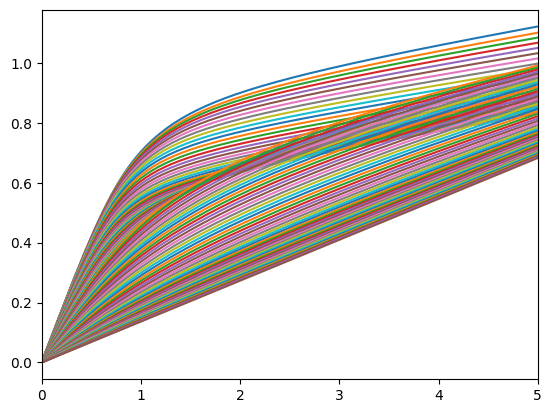

In [13]:
# Plot the consumption functions
print("Consumption functions")
plot_funcs(Agent.cFunc, 0, 5)

In [14]:
# Number of LifecycleExamples and periods in the simulation.
Agent.AgentCount = 500
Agent.T_sim = 200

# Set up the variables we want to keep track of.
Agent.track_vars = ["aNrm", "cNrm", "pLvl", "t_age", "mNrm"]

# Run the simulations
Agent.initialize_sim()
Agent.simulate()

{'aNrm': array([[ 1.79412644,  1.66743155,  0.57564762, ...,  3.15046858,
          1.19036934,  0.34459373],
        [ 1.39124841,  1.16566103,  1.48145047, ...,  2.88779527,
          1.26166512,  1.3099449 ],
        [ 0.98829161,  1.45107179,  1.52854256, ...,  1.92487178,
          1.06565007,  1.24057602],
        ...,
        [ 7.49051719,  7.75136436, 10.67806008, ..., 12.80044104,
          6.24639526,  1.91446752],
        [ 7.52532185,  7.74273045, 10.39431939, ..., 13.03795022,
          6.8443646 ,  1.91820761],
        [ 7.55945773,  7.73639185,  9.98542757, ..., 13.26628713,
          6.73471769,  1.99094224]]),
 'cNrm': array([[0.97047847, 0.95938038, 0.80968597, ..., 1.07298204, 0.91098692,
         0.72948666],
        [0.91628752, 0.89245789, 0.9249315 , ..., 1.03410186, 0.90306134,
         0.90803888],
        [0.85996645, 0.9095479 , 0.91663031, ..., 0.94940691, 0.86955367,
         0.88909245],
        ...,
        [1.2251448 , 1.28073342, 1.22037629, ..., 1.3752

In [15]:
raw_data = {
    "Age": Agent.history["t_age"].flatten() + birth_age - 1,
    "pIncome": Agent.history["pLvl"].flatten(),
    "nrmM": Agent.history["mNrm"].flatten(),
    "nrmC": Agent.history["cNrm"].flatten(),
}

Data = pd.DataFrame(raw_data)
Data["Cons"] = Data.nrmC * Data.pIncome
Data["M"] = Data.nrmM * Data.pIncome

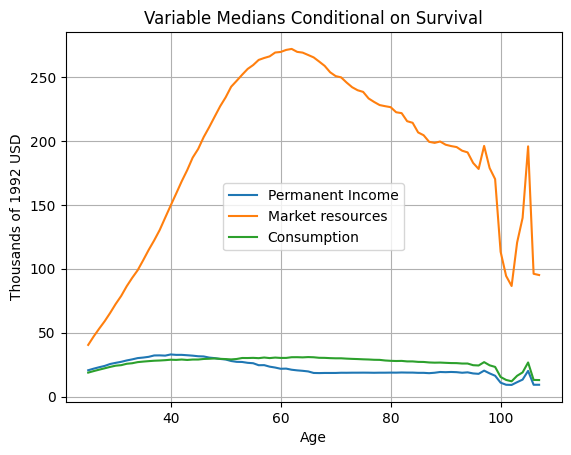

In [16]:
# Find the mean of each variable at every age
AgeMeans = Data.groupby(["Age"]).median().reset_index()

plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome, label="Permanent Income")
plt.plot(AgeMeans.Age, AgeMeans.M, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.Cons, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.ylabel(f"Thousands of {adjust_infl_to} USD")
plt.title("Variable Medians Conditional on Survival")
plt.grid()